In [68]:
import torch
from transformers import ViTForImageClassification, ViTFeatureExtractor

In [69]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [70]:
feature_extractor = ViTFeatureExtractor.from_pretrained('../outputs/CL_expression_z64_bs512/model/')
model = ViTForImageClassification.from_pretrained('../outputs/CL_expression_z64_bs512/model/')

/home/rkn/.local/share/virtualenvs/AffectNet-experiments-e17pgDV_/lib/python3.10/site-packages/transformers/models/vit/feature_extraction_vit.py:28: FutureWarning: The class ViTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use ViTImageProcessor instead.
  warnings.warn(


In [117]:
from torchaffectnet import AffectNetDataset
from torchvision.transforms import (Compose,
                                    Normalize,
                                    Resize,
                                    RandomResizedCrop,
                                    RandomHorizontalFlip,
                                    RandomApply,
                                    ColorJitter,
                                    RandomGrayscale,
                                    ToTensor,
                                    RandomAffine)

normalize = Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)

transform = Compose([
        Resize(tuple(feature_extractor.size.values())),
        ToTensor(),
    ])

# transform = Compose([
#         RandomResizedCrop(size=tuple(
#             feature_extractor.size.values()), scale=(0.2, 1.)),
#         RandomHorizontalFlip(),
#         RandomApply([
#             ColorJitter(0.4, 0.4, 0.4, 0.1)
#         ], p=0.8),
#         ToTensor(),
#         # normalize
#     ])


emotion_dataset = AffectNetDataset('../../Affectnet/validation.csv',
                                   '../../Affectnet/Manually_Annotated/Manually_Annotated_Images/',
                                   transform=transform,
                                   mode='classification')

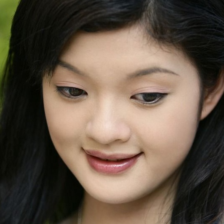

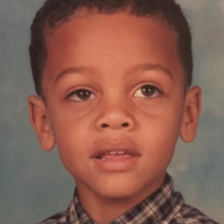

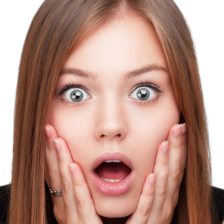

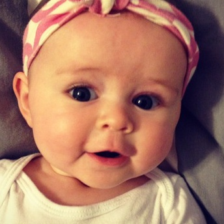

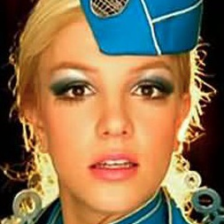

In [201]:
from torchvision.transforms import ToPILImage
from IPython.display import display

to_pil = ToPILImage()
sample_df = emotion_dataset.df[emotion_dataset.df['expression']==3].sample(n=5)
for idx in list(sample_df.index):
    image = to_pil(emotion_dataset[idx][0])
    display(image)

In [16]:
emotion_dataset[12]

(tensor([[[0.9098, 0.9059, 0.9059,  ..., 0.1569, 0.2118, 0.2941],
          [0.9098, 0.9059, 0.9059,  ..., 0.1765, 0.1882, 0.2353],
          [0.9098, 0.9059, 0.9098,  ..., 0.1569, 0.1843, 0.1804],
          ...,
          [0.8275, 0.8275, 0.8275,  ..., 0.1137, 0.1176, 0.1098],
          [0.8235, 0.8275, 0.8275,  ..., 0.1020, 0.1176, 0.1294],
          [0.8275, 0.8392, 0.8314,  ..., 0.1098, 0.1020, 0.1176]],
 
         [[0.8667, 0.8627, 0.8588,  ..., 0.1529, 0.2078, 0.2902],
          [0.8667, 0.8627, 0.8627,  ..., 0.1686, 0.1843, 0.2157],
          [0.8667, 0.8627, 0.8667,  ..., 0.1529, 0.1804, 0.1765],
          ...,
          [0.5255, 0.5333, 0.5333,  ..., 0.0902, 0.1098, 0.0863],
          [0.5255, 0.5333, 0.5255,  ..., 0.0941, 0.1098, 0.1059],
          [0.5333, 0.5451, 0.5333,  ..., 0.1059, 0.0824, 0.0980]],
 
         [[0.8667, 0.8627, 0.8549,  ..., 0.1412, 0.2000, 0.2824],
          [0.8824, 0.8627, 0.8627,  ..., 0.1608, 0.1765, 0.2157],
          [0.8824, 0.8667, 0.8667,  ...,

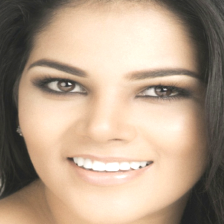

In [64]:
from torchvision.transforms import ToPILImage

to_pil = ToPILImage()
image = to_pil(emotion_dataset[12][0])
image

In [52]:
from tqdm import tqdm

def head_outputs(model, dataset, device):
    features = []
    labels = []
    for img, label in tqdm(dataset):
        if isinstance(img, tuple):
            img = img[0]
        with torch.no_grad():
            feature = model(img.unsqueeze(0).to(device)).logits
        # print(feature)
        features.append(feature.cpu())
        labels.append(label)
    return torch.stack(features).squeeze(), torch.tensor(labels)

In [6]:
features, labels = head_outputs(model.to(device), dataset, device)
# features, labels = CLS_tokens(model.to(device), dataset, device)

100%|██████████| 4000/4000 [00:45<00:00, 88.76it/s] 


plotting tokens...


4000it [00:10, 385.63it/s]


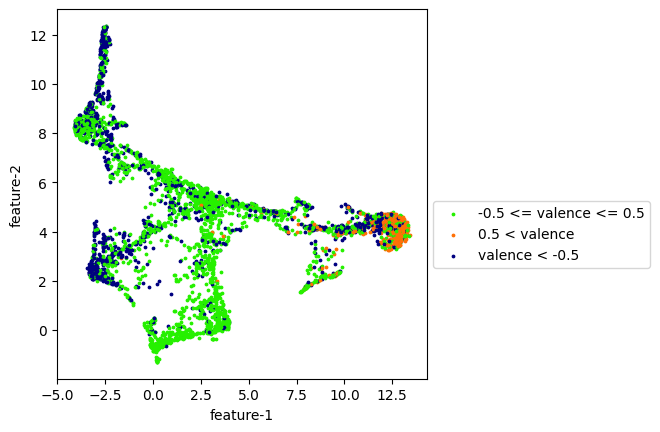

In [7]:
from utils import exclude_id

id2label = {
            0: 'valence < -0.5',
            1: '-0.5 <= valence <= 0.5',
            2: '0.5 < valence',
        }
fig = plot_tokens_category(features, labels, 20, id2label, 0)